In [4]:
import numpy as np
import torch, torch.nn as nn
import snntorch as snn
from snntorch import utils
from snntorch import surrogate
from snntorch import functional as SF
from tqdm import tqdm

import sys
sys.path.append('../src')
from dataloader import WISDM_Dataset_parser, WISDM_Dataset
from torch.utils.data import  DataLoader

In [5]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f'Using device {device}')

Using device cuda


In [6]:
batch_size = 256
# network parameters
num_inputs = 6 
num_steps = 40
num_hidden_1 = 64
num_hidden_2 = 256
num_hidden_3 = 64
num_outputs = 18
pop_outputs = num_outputs * 10
num_epochs = 100

# spiking neuron parameters
beta = 0.9  # neuron decay rate
grad = surrogate.fast_sigmoid()

In [7]:

dataset = WISDM_Dataset_parser('../data/data_watch_40.npz', norm='std')
train_set = dataset.get_training_set()
test_set = dataset.get_validation_set()

train_dataset = WISDM_Dataset(train_set)
test_dataset = WISDM_Dataset(test_set)

train_loader = DataLoader(dataset=train_dataset, batch_size=int(batch_size), shuffle=True, num_workers=8)
test_loader  = DataLoader(dataset= test_dataset, batch_size=int(batch_size), shuffle=True, num_workers=8)

(6,)
(6,)
num classes train dataset: 18 occurrences of each class:[6299 6119 5674 6286 6232 6164 6287 5934 6155 6340 6181 6163 6282 6038
 5984 6024 6176 6469]
num classes eval dataset: 18 occurrences of each class:[2115 2058 1846 2103 2018 2069 2072 1985 1945 2193 2044 2089 2090 2014
 2010 2014 2107 2164]
num classes test dataset: 18 occurrences of each class:[2008 2012 1856 2157 2031 2080 2182 1987 2056 2135 2109 2077 2092 2000
 1937 2046 2115 2056]


In [8]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, num_hidden_1),
                    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True, learn_beta=True,  learn_threshold=True),
                    nn.Linear(num_hidden_1, num_hidden_2),
                    snn.RLeaky(beta=beta, spike_grad=grad, init_hidden=True,all_to_all=True, learn_beta=True, learn_threshold=True,linear_features=num_hidden_2, learn_recurrent=True),
                    nn.Linear(num_hidden_2, num_outputs),
                    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True,learn_beta=True,  learn_threshold=True, output=True)
                    ).to(device)

In [9]:
def forward_pass(net, data):  
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(2)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[:,:,step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

In [10]:

def test_accuracy(data_loader, net, num_steps, population_code=False, num_classes=False):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    tqdm_dataloader = tqdm(data_loader)
    for _, batch  in enumerate(tqdm_dataloader):
      data, targets = batch
      data = data.to(device)
      targets = targets.to(device)
      spk_rec = forward_pass(net, data)

      if population_code:
        acc += SF.accuracy_rate(spk_rec, targets, population_code=True, num_classes=num_outputs) * spk_rec.size(1)
      else:
        acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)

      total += spk_rec.size(1)
      tqdm_dataloader.set_description(f'\r[Test accuracy: {acc/total:.3f}]')
  return acc/total

In [11]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
    T_max=4690, 
    eta_min=0, 
    last_epoch=-1
)
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2, num_classes=num_outputs, population_code=False)

In [12]:
train_acc_hist = []
train_loss_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(num_epochs):
    tqdm_dataloader = tqdm(train_loader)
    for i, batch in enumerate(tqdm_dataloader):
        data, targets = batch
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        scheduler.step()

        # Store loss history for future plotting
        train_loss_hist.append(loss_val.item())
        acc = SF.accuracy_rate(spk_rec, targets) 
        train_acc_hist.append(acc)
        tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{num_epochs}] loss:{loss_val.item():.2f} accuracy:{acc * 100:.2f}')
    
    test_acc = test_accuracy(test_loader, net, num_steps, num_classes=num_outputs)
    test_acc_hist.append(test_acc)
    


Epoch 0, Iteration 0 
Train Loss: 2.93
Accuracy: 5.86%

Epoch 0, Iteration 1 
Train Loss: 2.84
Accuracy: 7.42%

Epoch 0, Iteration 2 
Train Loss: 2.68
Accuracy: 8.59%

Epoch 0, Iteration 3 
Train Loss: 2.38
Accuracy: 6.64%

Epoch 0, Iteration 4 
Train Loss: 1.87
Accuracy: 7.03%

Epoch 0, Iteration 5 
Train Loss: 1.62
Accuracy: 4.69%

Epoch 0, Iteration 6 
Train Loss: 1.21
Accuracy: 8.59%

Epoch 0, Iteration 7 
Train Loss: 0.95
Accuracy: 9.77%

Epoch 0, Iteration 8 
Train Loss: 0.91
Accuracy: 6.25%

Epoch 0, Iteration 9 
Train Loss: 0.89
Accuracy: 5.08%

Epoch 0, Iteration 10 
Train Loss: 0.91
Accuracy: 6.64%

Epoch 0, Iteration 11 
Train Loss: 0.89
Accuracy: 8.20%

Epoch 0, Iteration 12 
Train Loss: 0.89
Accuracy: 6.64%

Epoch 0, Iteration 13 
Train Loss: 0.84
Accuracy: 6.25%

Epoch 0, Iteration 14 
Train Loss: 0.82
Accuracy: 9.77%

Epoch 0, Iteration 15 
Train Loss: 0.80
Accuracy: 8.59%

Epoch 0, Iteration 16 
Train Loss: 0.79
Accuracy: 8.98%

Epoch 0, Iteration 17 
Train Loss: 0.77
A

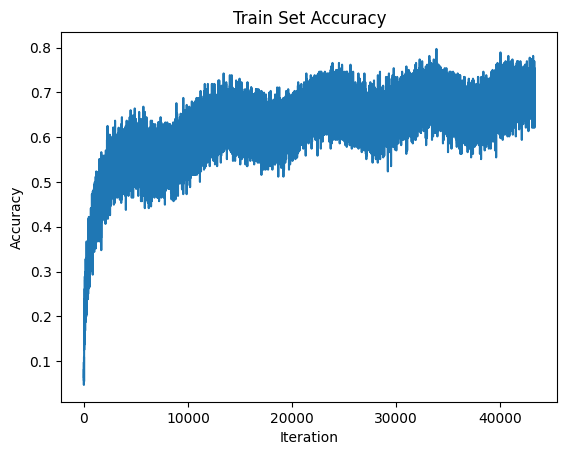

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(facecolor="w")
plt.plot(train_acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

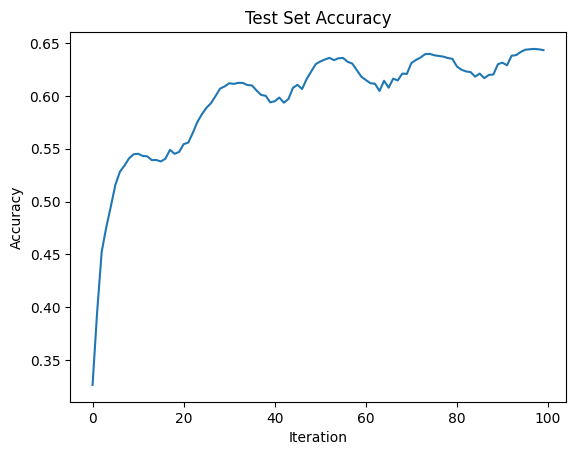

In [14]:
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()